# Recursive Binary Splitting

In order to perform recursive binary splitting, we first select the predictor $X_j$ and the cutpoint $s$ such that the splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j\geq s\}$ leads to the greatest possible reduction in RSS. (The notation $\{X|X_j < s\}$ means the the region of predictor space in which $X_j$ takes on a value less than $s$.) That is, we consider all predictors $X_1,...,X_p$ and all possible values of the cutpoint $s$ for each of the predictors, and then choose the predictor and cutpoint such that the resulting tree has the lowest RSS.

# Cost Complexity Pruning

https://www.isip.piconepress.com/courses/msstate/ece_8463/lectures/current/lecture_27/lecture_27_07.html

https://medium.com/@sanchitamangale12/decision-tree-pruning-cost-complexity-method-194666a5dd2f

<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 11: Decision Trees</h2>
<br>
 
This tutorial shows you how to apply decision trees to classification problems using Python.  
 
<a href="#1.-Work-Analytics-Data">Work analytics data</a> <br>
<a href="#2.-Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#3.-Feature-Engineering">Feature engineering</a> <br>
<a href="#4.-Classification-Tree">Classification tree</a> <br>
<a href="#5.-Bagging">Bagging</a> <br>
<a href="#6.-Probability-Calibration">Probability Calibration</a> <br>
<a href="#7.-Evaluation">Evaluation</a> <br>
<a href="#8.-Things to try">Things to try</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

## 1. HR Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data available from [Kaggle Datasets](https://www.kaggle.com/datasets).

**Problem formulation:**  our objective is predict which employees will leave the company with the highest possible accuracy (zero-one loss).

In [4]:
data = pd.read_csv('Data\HR.csv')
data = data.rename(columns = {'sales' : 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
response='left' # whether the employee left the company
predictors = list(data.columns.values)
predictors.remove(response)

index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)

train = data.loc[index_train,].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

In [6]:
len(train)

10499

## 2. Exploratory Data Analysis


### 2.1 Descriptive statistics

In [7]:
train.describe().round(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00
mean,0.62,0.72,3.79,200.92,3.51,0.14,0.24,0.02
std,0.25,0.17,1.22,49.74,1.48,0.35,0.43,0.15
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.65,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


## 2.2 Relationship between the response and numerical predictors

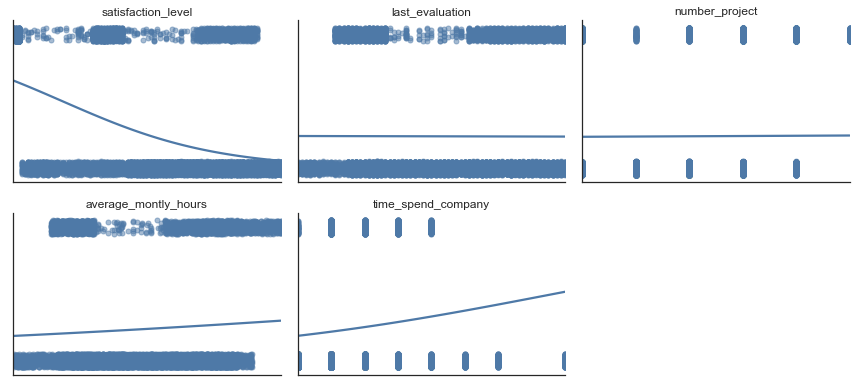

In [8]:
from statlearning import plot_logistic_regressions
plot_logistic_regressions(train[predictors].iloc[:,:5], y_train)
plt.show()

## 2.3 Relationship between the response and nominal predictors

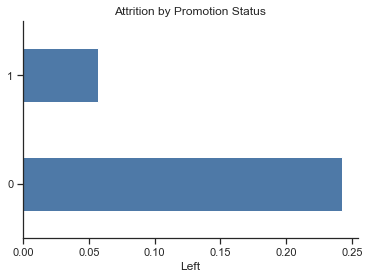

In [9]:
table = (train.groupby('promotion_last_5years')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Promotion Status')
sns.despine()
plt.show()

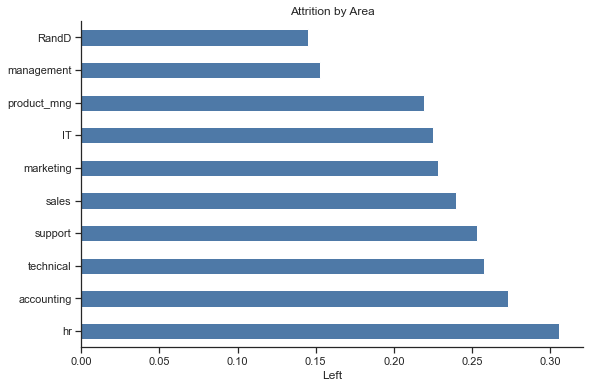

In [10]:
table = (train.groupby('role')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Area')
sns.despine()
plt.show()

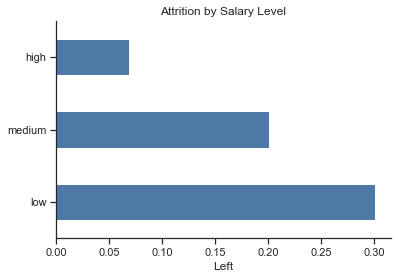

In [11]:
table = (train.groupby('salary')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Salary Level')
sns.despine()
plt.show()

## 3. Feature Engineering

As mentioned in the lectures, we generally want to process the data in a specialised way for tree-based methods. We use one-hot encoding of the nominal variables for the tree-based algorithms but and dummy encoding for the logistic regression model.

In [12]:
def feat_engineering(df, index_train, index_test):
    
    data = df.copy()
    dummies = pd.get_dummies(data['role'])
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'],  prefix = 'salary')
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    predictors = list(data.columns.values)
    predictors.remove(response)
    
    X_train = data.loc[index_train, predictors].copy()
    X_test =  data.loc[index_test, predictors].copy()
    
    return X_train, X_test, predictors


def feat_engineering_logit(df, index_train, index_test):
    
    data = df.copy()
    dummies = pd.get_dummies(data['role'], drop_first=True)
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'],  prefix = 'salary', drop_first=True)
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    predictors = list(data.columns.values)
    predictors.remove(response)
       
    X_train = data.loc[index_train, predictors].copy()
    X_test =  data.loc[index_test, predictors].copy()
    
    return X_train, X_test


X_train, X_test, predictors = feat_engineering(data, index_train, index_test)
X_train_logit, X_test_logit = feat_engineering_logit(data, index_train, index_test)

## 4. Classification Tree

### 4.1 Fitting a classification tree

The basic syntax for fitting a classification tree is as follows. We start with a small tree with tree leaves for visualisation.

In [48]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=2)
#tree = DecisionTreeClassifier(criterion='entropy', min_samples_split=1000)

"""
    min_samples_leaf  (int): The minimum number of samples required to be at a leaf node
    max_depth         (int): The maximum depth of the tree. 
    min_samples_split (int): The minimum number of samples required to split an internal node
    max_leaf_nodes    (int): Grow a tree with max_leaf_nodes in best-first fashion
"""

tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

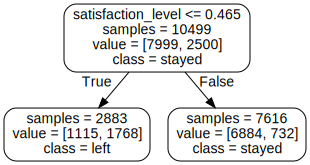

In [49]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors, 
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

Increasing the number of leaves to three allows to visualise how recursive binary splitting grows the tree in a greedy way. The top node remains the same as we add a new decision node on the right-hand side.

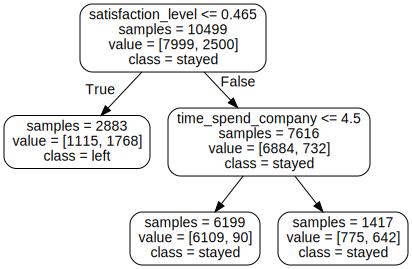

In [15]:
tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=3)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors, 
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

### 4.2 Cost-complexity pruning

In practice, we use cost-complexity pruning to fit the tree. We start by growing a full tree by recursive binary splitting, subject a minimum number of samples in each leaf.  We then obtain a sequence of subtrees that minimise the cost-complexity objective function for the full range of values of the penalty hyperparameter $\alpha$.  Finally, we use a model selection method to choose $\alpha$. 

To implement this approach, we first obtain the full path of the alphas. 

In [16]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas, impurities = path.ccp_alphas, path.impurities

In [17]:
alphas

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.31951182e-05, 8.84159793e-05, 1.02896987e-04, 1.06621152e-04,
       1.16661242e-04, 1.16661242e-04, 1.29170562e-04, 1.29170562e-04,
       1.38775062e-04, 1.40634904e-04, 1.40634904e-04, 1.51215554e-04,
       1.67585893e-04, 1.77275270e-04, 1.78800631e-04, 1.83609580e-04,
       1.91863815e-04, 1.92019471e-04, 1.92693360e-04, 1.92693360e-04,
       1.94526360e-04, 1.96249818e-04, 1.99737165e-04, 2.01761946e-04,
       2.02466618e-04, 2.05754369e-04, 2.10620391e-04, 2.17804966e-04,
       2.18163068e-04, 2.22762300e-04, 2.22875622e-04, 2.23668949e-04,
       2.25214590e-04, 2.35182781e-04, 2.38308234e-04, 2.38509094e-04,
       2.48527187e-04, 2.50401887e-04, 2.63347700e-04, 2.64181722e-04,
       2.70205075e-04, 2.70894573e-04, 2.70939271e-04, 2.72141503e-04,
       2.81293657e-04, 2.84346070e-04, 2.87916373e-04, 2.88255284e-04,
       2.93391319e-04, 2.93952497e-04, 2.94366806e-04, 3.03577111e-04,
      

We then run a grid search to find the best $\alpha$.

In [18]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv = 5 , scoring='neg_log_loss')
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.0016680985845902233} 



In [19]:
best_alpha = np.argwhere(alphas == tree_search.best_params_['ccp_alpha'])[0, 0]
print(f'Best Alpha: {best_alpha}')

Best Alpha: 121


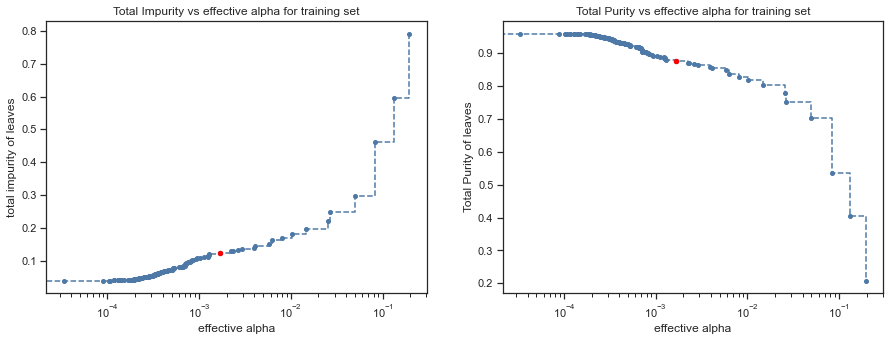

In [20]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, impurities, 'o--', markersize = 4, drawstyle = "steps-post", zorder = 1)
plt.scatter(alphas[best_alpha], impurities[best_alpha], color = 'red', s = 20, zorder = 2)

plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set");

plt.xscale('log');

plt.subplot(1, 2, 2)
plt.plot(alphas, 1 - impurities, 'o--', markersize = 4, drawstyle = "steps-post", zorder = 1)
plt.scatter(alphas[best_alpha], 1 - impurities[best_alpha], color = 'red', s = 20, zorder = 2)

plt.xlabel("effective alpha")
plt.ylabel("Total Purity of leaves")
plt.title("Total Purity vs effective alpha for training set");

plt.xscale('log');

In [21]:
clfs = []
for alpha in alphas:
    clf = DecisionTreeClassifier(criterion='entropy', ccp_alpha=alpha, min_samples_leaf=5)
    clf.fit(X_train, y_train)
    clfs.append(clf)

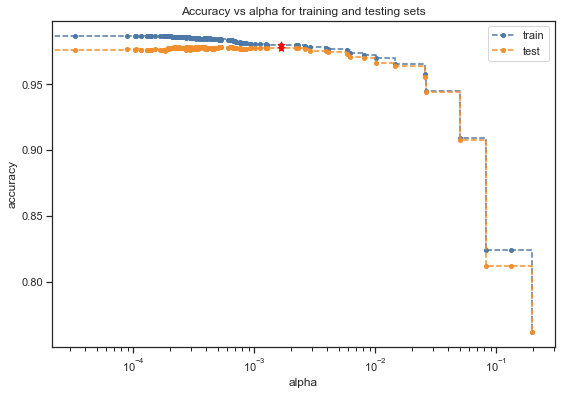

In [22]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores  = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, 'o--', markersize = 4, label="train", drawstyle="steps-post", zorder = 1)
ax.plot(alphas, test_scores, 'o--', markersize = 4, label="test", drawstyle="steps-post", zorder = 2)
ax.legend()

ax.scatter(alphas[best_alpha], train_scores[best_alpha], marker = '*', color = 'red', s = 50, zorder = 3)
ax.scatter(alphas[best_alpha], test_scores[best_alpha], marker = '*', color = 'red', s = 50, zorder = 3)
plt.xscale('log');
plt.show()

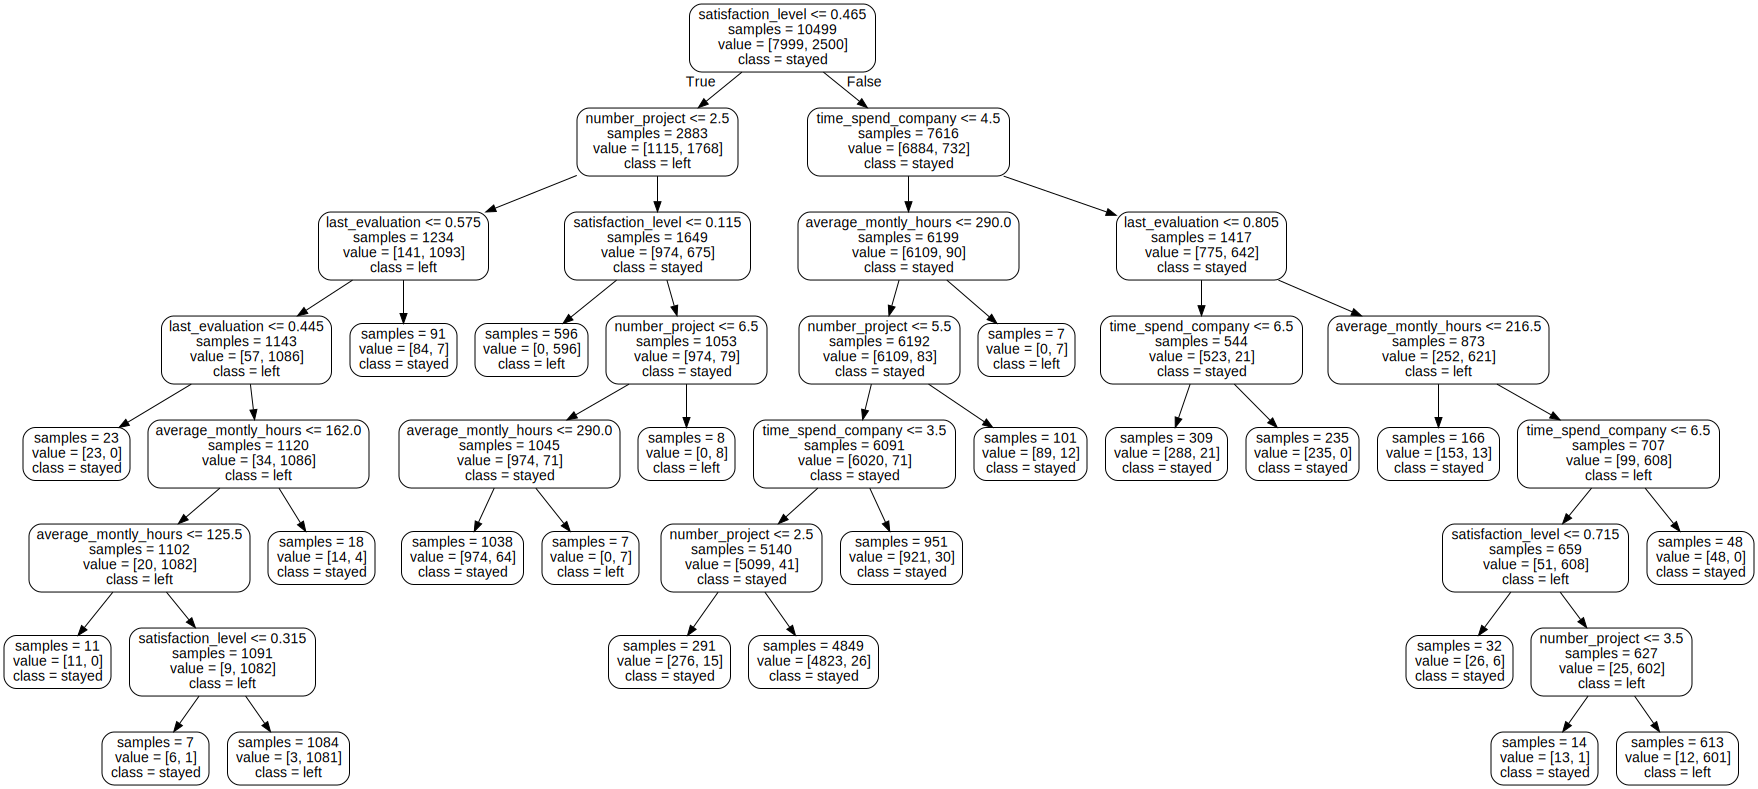

In [23]:
# import os
# os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

## 5. Bagging

Bagging predicts the response using majority voting or averaging across a large number of trees fitted on different versions of the data. We will discuss this method in the Week 11 lecture, but anticipate an application here since the code is very simple.


#### Aside
As from documentation

    A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.



In [24]:
from sklearn.ensemble import BaggingClassifier

"""
    min_samples_leaf  (int): The minimum number of samples required to be at a leaf node
    max_depth         (int): The maximum depth of the tree. 
    min_samples_split (int): The minimum number of samples required to split an internal node
    max_leaf_nodes    (int): Grow a tree with max_leaf_nodes in best-first fashion
"""

bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=Non

## 6. Probability Calibration

A reliability curve is a a figure allows us to check whether a probabilistic model for classification produces well-calibrated probabilities. If a model is well-calibrated, then among cases for which it estimates probabilities close to (say) 0.5, around 50% of these cases should be actual positives. 

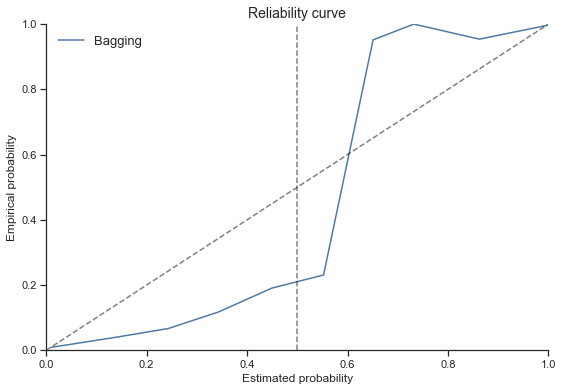

In [25]:
from statlearning import plot_calibration_curves
from sklearn.model_selection import cross_val_predict

y_prob = cross_val_predict(bag, X_train, y_train, cv = 5, method='predict_proba')[:,1]
fig, ax = plot_calibration_curves(y_train, y_prob, labels='Bagging')
ax.axvline(0.5, color='black', linestyle='dashed', alpha = 0.5) # decision threshold
plt.show()

In [26]:
empirical_probabilities = []
for i in np.arange(0, 1, 0.1):
    working_indicies = (i < y_prob) * (y_prob < i + 0.1)
    empirical_probability = np.mean(y_train[working_indicies])
    empirical_probabilities.append(empirical_probability)
    print(f'Bin {round(i, 1)} < y_prob < {round(i + 0.1, 1)} = {format(empirical_probability, ".3f")}')

Bin 0.0 < y_prob < 0.1 = 0.012
Bin 0.1 < y_prob < 0.2 = 0.041
Bin 0.2 < y_prob < 0.3 = 0.067
Bin 0.3 < y_prob < 0.4 = 0.118
Bin 0.4 < y_prob < 0.5 = 0.190
Bin 0.5 < y_prob < 0.6 = 0.250
Bin 0.6 < y_prob < 0.7 = 0.952
Bin 0.7 < y_prob < 0.8 = 1.000
Bin 0.8 < y_prob < 0.9 = 0.953
Bin 0.9 < y_prob < 1.0 = 0.987


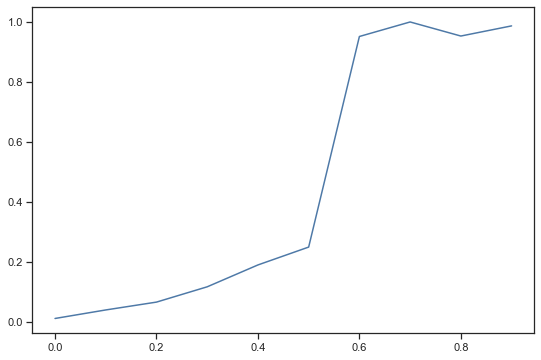

In [27]:
plt.plot(np.arange(0, 1, 0.1), empirical_probabilities);

Bagging seems to be poorly calibrated, as common with many tree-based methods. In this case, it can be useful to apply  probability calibration methods to try improve the estimates. We do not cover the details of probability calibration in this unit, but the code below shows the application. 

In [28]:
%%time 
from sklearn.calibration import CalibratedClassifierCV
bag_cal = CalibratedClassifierCV(bag, cv = 5, method='isotonic') 
bag_cal.fit(X_train, y_train)

Wall time: 1min 30s


CalibratedClassifierCV(base_estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                              class_weight=None,
                                                                                              criterion='entropy',
                                                                                              max_depth=None,
                                                                                              max_features=None,
                                                                                              max_leaf_nodes=None,
                                                                                              min_impurity_decrease=0.0,
                                                                                              min_impurity_split=None,
                                                                                     

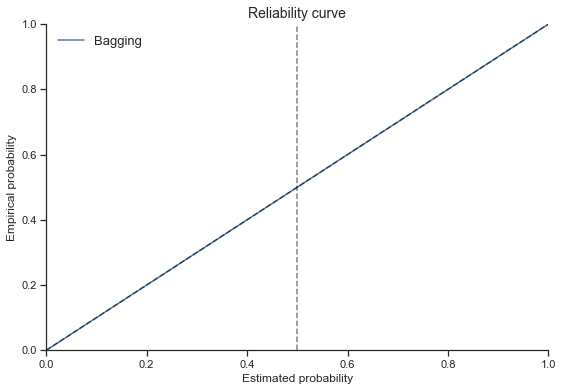

In [29]:
y_prob_calibrated = bag_cal.predict(X_train)
fig, ax = plot_calibration_curves(y_train, y_prob_calibrated, labels='Bagging')
ax.axvline(0.5, color='black', linestyle='dashed', alpha = 0.5) # decision threshold
plt.show()

In [30]:
empirical_probabilities = []
for i in np.arange(0, 1, 0.1):
    working_indicies = (i < y_prob_calibrated) * (y_prob_calibrated < i + 0.1)
    empirical_probability = np.mean(y_train[working_indicies])
    empirical_probabilities.append(empirical_probability)
    print(f'Bin {round(i, 1)} < y_prob < {round(i + 0.1, 1)} = {format(empirical_probability, ".3f")}')

Bin 0.0 < y_prob < 0.1 = nan
Bin 0.1 < y_prob < 0.2 = nan
Bin 0.2 < y_prob < 0.3 = nan
Bin 0.3 < y_prob < 0.4 = nan
Bin 0.4 < y_prob < 0.5 = nan
Bin 0.5 < y_prob < 0.6 = nan
Bin 0.6 < y_prob < 0.7 = nan
Bin 0.7 < y_prob < 0.8 = nan
Bin 0.8 < y_prob < 0.9 = nan
Bin 0.9 < y_prob < 1.0 = nan


In [31]:
y_prob_calibrated[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

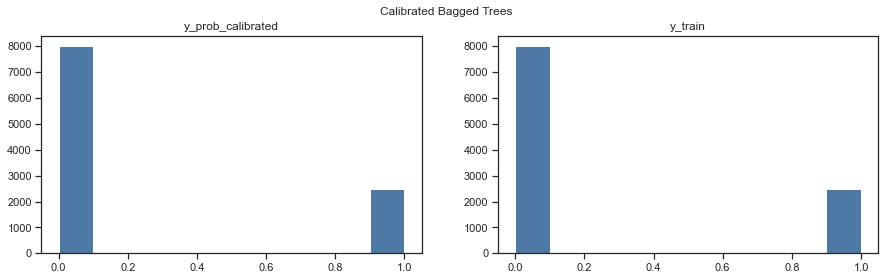

In [32]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 2, 1)
plt.hist(y_prob_calibrated);
plt.title('y_prob_calibrated')

plt.subplot(1, 2, 2)
plt.hist(y_train);
plt.title('y_train');

plt.suptitle('Calibrated Bagged Trees');

## 7. Model Evaluation

Our benchmark will be the logistic regression model:

In [33]:
logit = LogisticRegression(penalty='none')
logit.fit(X_train_logit, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The results show that the decision tree and bagging strongly outperform the logistic regression for this dataset. Note how probability calibration substantially improves the cross-entropy. 

In [34]:
columns = ['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows = ['Logistic', 'Classification Tree', 'Bagged trees', 'Bagged trees (calibrated)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, bag_cal]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    
    if i==0:
        y_prob[:, i] = method.predict_proba(X_test_logit)[:, 1]
        y_pred = method.predict(X_test_logit)
    else:
        y_prob[:, i] = method.predict_proba(X_test)[:, 1]
        y_pred = method.predict(X_test)
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_test, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,5] =  log_loss(y_test, y_prob[:,i])

    
results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.193,0.446,0.920,0.636,0.813,0.432
Classification Tree,0.022,0.920,0.996,0.986,0.982,0.093
Bagged trees,0.010,0.971,0.996,0.988,0.992,0.094
Bagged trees (calibrated),0.009,0.970,0.997,0.991,0.993,0.049


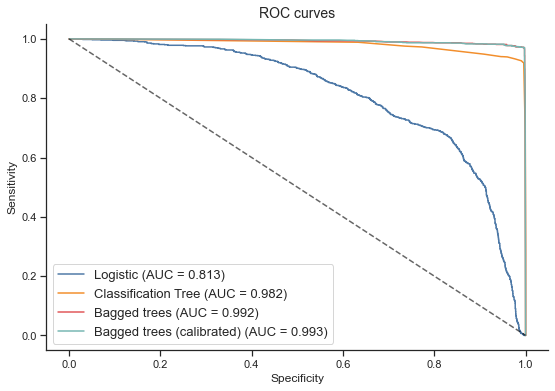

In [35]:
from statlearning import plot_roc_curves
fig, ax = plot_roc_curves(y_test, y_prob, labels=pd.Series(rows))
plt.show()

In [36]:
print(f'Pruned Tree: Depth = {tree.get_depth()}, Number of Leaves = {tree.get_n_leaves()}')

Pruned Tree: Depth = 7, Number of Leaves = 22


In [37]:
for i, bagged_tree in enumerate(bag.estimators_[:5]):
    print(f'Bagged Tree {i}: Depth = {bagged_tree.get_depth()}, Number of Leaves = {bagged_tree.get_n_leaves()}')
    print(f'Train Score: {format(bagged_tree.score(X_train, y_train), ".3f")}')
    print(f'Test Score : {format(bagged_tree.score(X_test, y_test), ".3f")}')
    print('---------------')

Bagged Tree 0: Depth = 18, Number of Leaves = 224
Train Score: 0.991
Test Score : 0.976
---------------
Bagged Tree 1: Depth = 18, Number of Leaves = 216
Train Score: 0.990
Test Score : 0.974
---------------
Bagged Tree 2: Depth = 20, Number of Leaves = 212
Train Score: 0.990
Test Score : 0.973
---------------
Bagged Tree 3: Depth = 19, Number of Leaves = 216
Train Score: 0.991
Test Score : 0.971
---------------
Bagged Tree 4: Depth = 17, Number of Leaves = 207
Train Score: 0.989
Test Score : 0.969
---------------


## 8. Things to try

The logistic regression model performs very poorly relative to the tree-based methods. It's instructive to investigate why this is the case. Can you reduce the gap with feature engineering?

Does it affect the results if you use the Gini index as the node impurity measure?  

### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [38]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [39]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'